# Pre Analisis Wine Classification

Este notebook sera usado para realizar un analisis previo de que algoritmos usar para los experimentos

In [0]:
%pip install -q prettytable

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

Las columnas se toman basada en la descripción de
https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.names
Columnas en el archivo
  1) Class
  2) Alcohol
  3) Malic acid
  4) Ash
  5) Alcalinity of ash  
  6) Magnesium
  7) Total phenols
  8) Flavanoids
  9) Nonflavanoid phenols
  10) Proanthocyanins
  11) Color intensity
  12) Hue
  13) OD280/OD315 of diluted wines
  14) Proline  

In [0]:
import os
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from prettytable import PrettyTable

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, classification_report,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [0]:
"""
Leer los datos y asignar columnas
"""
def read_data():
  file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
  df = pd.read_csv(f"{file_name}", sep=",", header=None, engine='python')
  COL_NAMES = ["wine_class", "alcohol", "malic_acid", "ash", "alcalinity_of_ash", "magnesium", "total_phenols", "flavanoids", "nonflavanoid_phenols", "proanthocyanins", "color_intensity", "hue", "od280_od315_of_diluted_wines", "proline"]
  df.columns = COL_NAMES  
  return df


## Exploratory Data Analysis

In [0]:
"""
Esta función muestra la información referente a campos vacios y su % de incidencia en el dataframe
"""
def print_missing_values(data_frame):
    for column_name in data_frame.columns:
        length = len(data_frame[column_name])
        count = data_frame[column_name].count()
        number_of_missing_values = length - count
        pct_of_missing_values = float(number_of_missing_values / length)
        pct_of_missing_values = "{0:.1f}%".format(pct_of_missing_values*100)
        print(column_name, ": ", pct_of_missing_values)

In [0]:
wine_dataframe = read_data()
wine_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   wine_class                    178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  od280_od315_of_diluted_wines  178 non-null    float64
 13  proli

In [0]:
#Establecer numero de filas y columnas
nrows, ncols = wine_dataframe.shape
print(f"Cantidad de filas: {nrows}")
print(f"Cantidad de columnas: {ncols}")

Cantidad de filas: 178
Cantidad de columnas: 14


In [0]:
wine_dataframe.describe()

,wine_class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,1.943503,12.993672,2.339887,2.366158,19.516949,99.587571,2.292260,2.023446,0.362316,1.586949,5.054802,0.956983,2.604294,745.096045
std,0.773991,0.808808,1.119314,0.275080,3.336071,14.174018,0.626465,0.998658,0.124653,0.571545,2.324446,0.229135,0.705103,314.884046
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.360000,1.600000,2.210000,17.200000,88.000000,1.740000,1.200000,0.270000,1.250000,3.210000,0.780000,1.930000,500.000000
50%,2.000000,13.050000,1.870000,2.360000,19.500000,98.000000,2.350000,2.130000,0.340000,1.550000,4.680000,0.960000,2.780000,672.000000
75%,3.000000,13.670000,3.100000,2.560000,21.500000,107.000000,2.800000,2.860000,0.440000,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [0]:
wine_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
wine_class,178.0,1.938202,0.775035,1.00,1.0000,2.000,3.0000,3.00
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58


Visualizar el campo wine_class que sera luego renombrado a Variedad. De acuerdo a la información del archivo, el campo wine_class deberia estar con las siguientes caracteristicas Number of Instances

- class 1: 59
- class 2: 71
- class 3: 48

In [0]:
wine_dataframe.groupby('wine_class')['wine_class'].count().to_frame()

,wine_class
wine_class,
1,59
2,71
3,48


1    59
2    71
3    48
Name: wine_class, dtype: int64

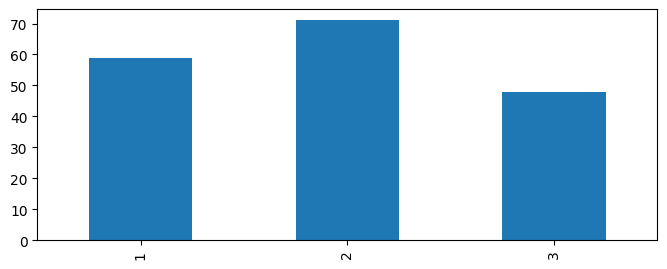

In [0]:
display(wine_dataframe.wine_class.value_counts().sort_index())
plt.figure(figsize=(8,3))
wine_dataframe.wine_class.value_counts().sort_index().plot(kind='bar')
plt.show()

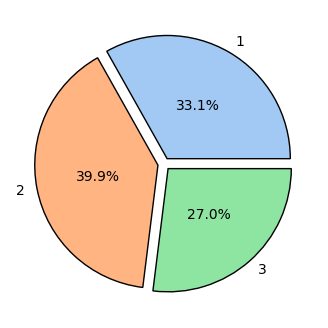

In [0]:
plt.figure(figsize=(4,4))
colors = sns.color_palette('pastel')[0:5]
df_predclass = wine_dataframe.groupby(['wine_class'])['wine_class'].count()
df_predclass
plt.pie(df_predclass, labels = ["1", "2", "3"], colors = colors, autopct='%.1f%%',
    explode=[0.05]*3, wedgeprops={"edgecolor":"black"},pctdistance=0.5 )
 
plt.show()

In [0]:
#Evaluar Valores faltantes por columna
print_missing_values(wine_dataframe)

wine_class :  0.0%
alcohol :  0.0%
malic_acid :  0.0%
ash :  0.0%
alcalinity_of_ash :  0.0%
magnesium :  0.0%
total_phenols :  0.0%
flavanoids :  0.0%
nonflavanoid_phenols :  0.0%
proanthocyanins :  0.0%
color_intensity :  0.0%
hue :  0.0%
od280_od315_of_diluted_wines :  0.0%
proline :  0.0%


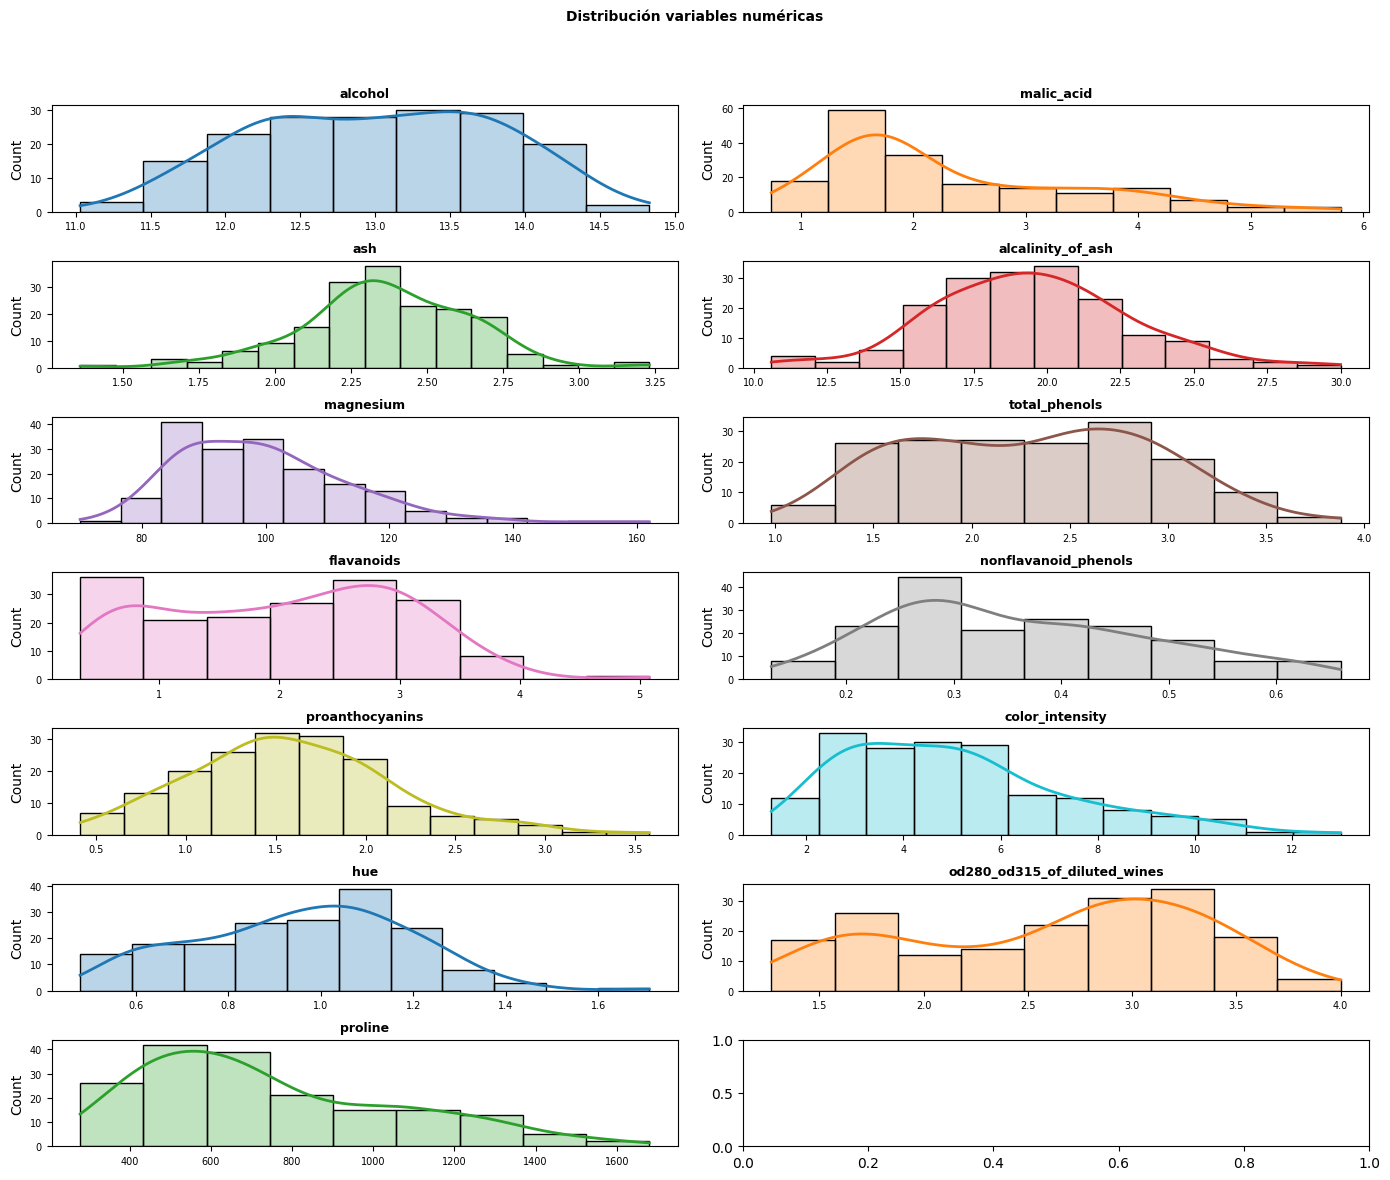

In [0]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(14, 12))
axes = axes.flat
columnas_numeric = wine_dataframe.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('wine_class')
for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = wine_dataframe,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 9, fontweight = "bold")
    axes[i].tick_params(labelsize = 7)
    axes[i].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La representación en diagrama de pares de los datos con diferenciación entre la única característica categórica, la clase del vino, revela algunas observaciones interesantes sobre la correlación de las características de cada tipo.

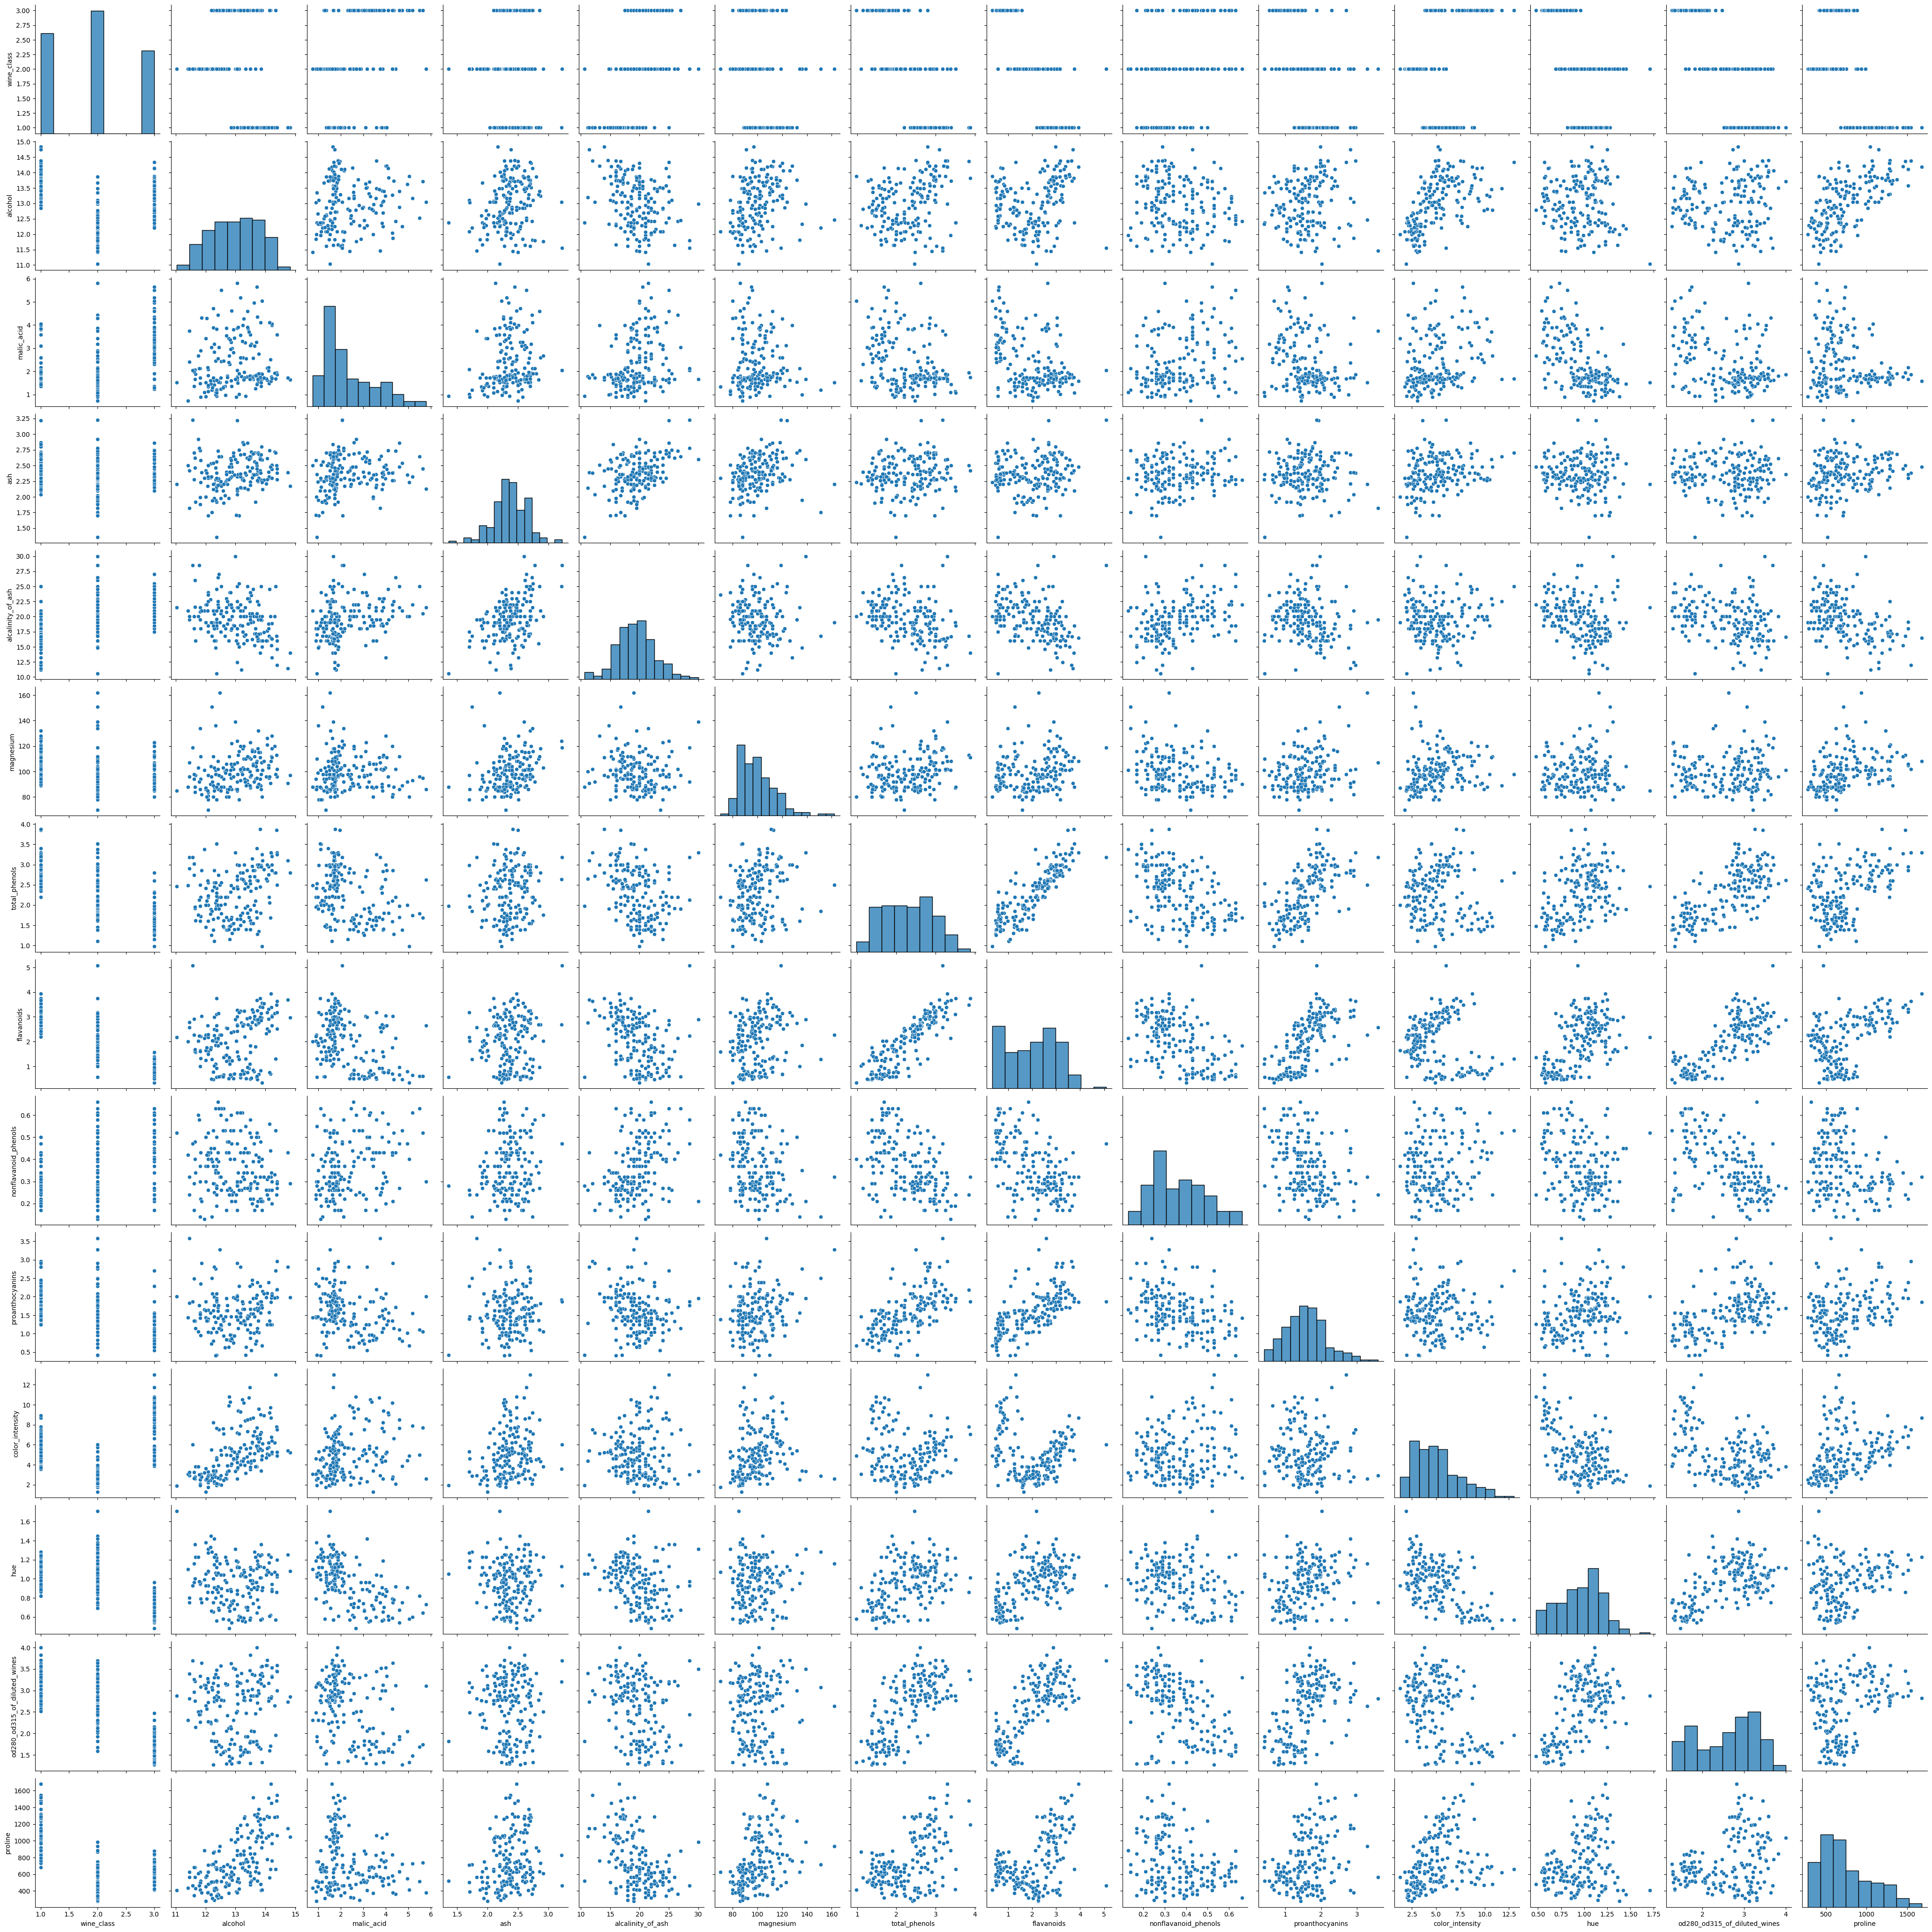

In [0]:
# Seaborn diagrama de pares
sns_plot = sns.pairplot(wine_dataframe, height=3)
plt.show()

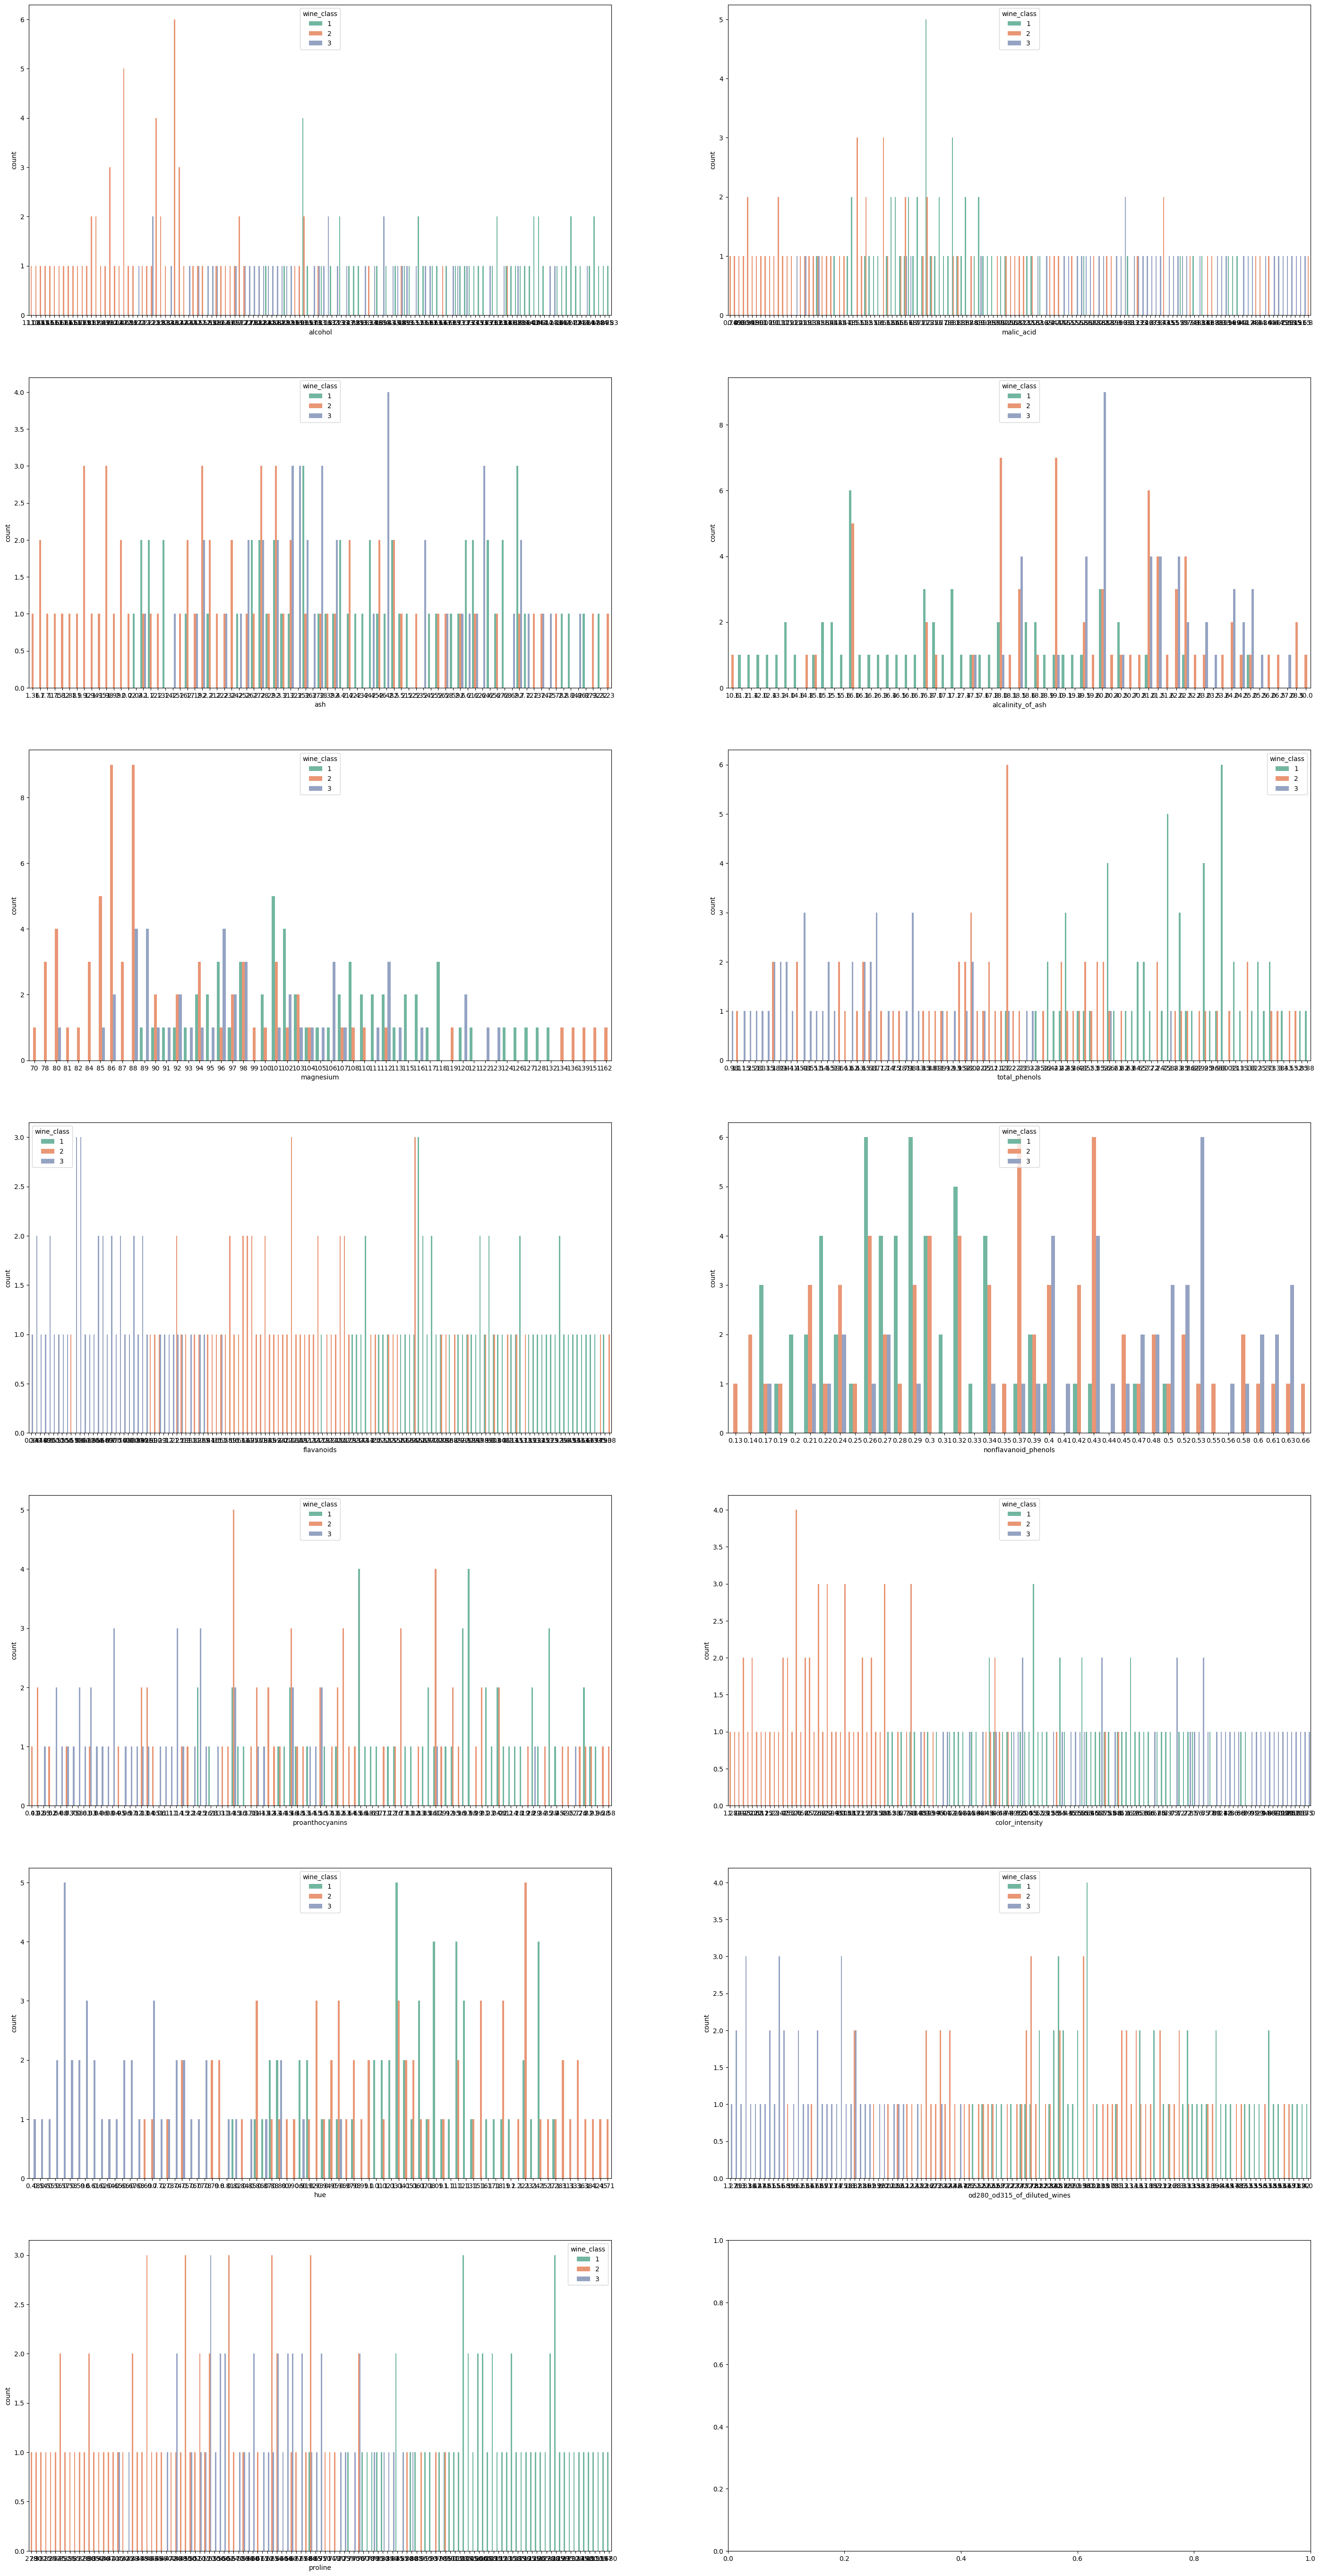

In [0]:
# Este proceso traza gráficos, agrupa por características categóricas en cols_graph
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(35,70))
cols_graph = wine_dataframe.columns
pos = 0
for idx, feature in enumerate(cols_graph):
    if feature != 'wine_class':
        ax = axes[int(pos/2), pos%2]
        sns.countplot(x=feature, hue='wine_class', data=wine_dataframe, ax=ax, palette='Set2')
        pos += 1


<AxesSubplot:>

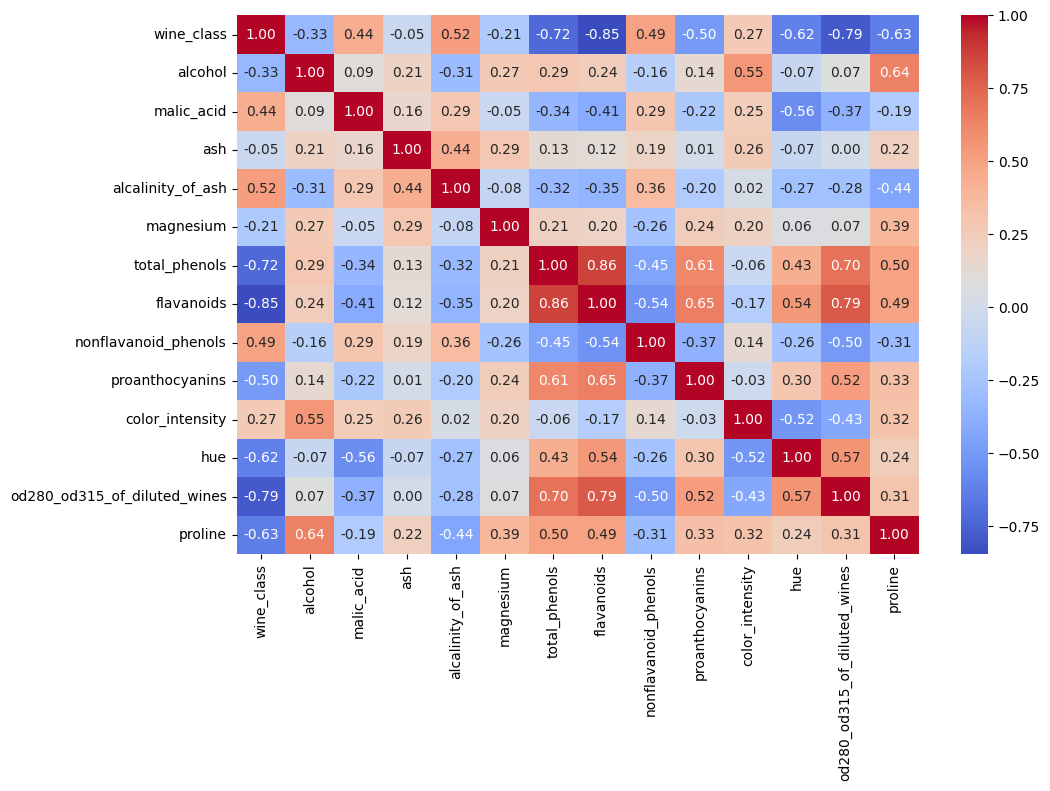

In [0]:
plt.figure(figsize=(11,7))
sns.heatmap(wine_dataframe.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Probar varios Algoritmos y luego incluirlos en el flujo del proceso

El objetivo de este proceso es probar el entrenamiento con diferentes algoritmos (sin usar mucho parametro de tuning o cambiar hiperparametros, solo los basicos) para ver cual tiene mejor accuracy en su evaluacion.

Para ellos se hace un split de los datos, donde el 80% se usara para entrenamiento y el otro 20% para test


In [0]:
wine_dataframe = read_data()
X = wine_dataframe.iloc[: , 1:].values
y = wine_dataframe.iloc[: ,0].values

### Evaluar el numero de vecinos (n_neighbors)

In [0]:
k_values = [i for i in range (1,10)]
scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

mejor_index = np.argmax(scores)
mejor_k = k_values[mejor_index]    
print(f"Mejor score {mejor_k}")

Mejor score 7


Text(0, 0.5, 'Accuracy Score')

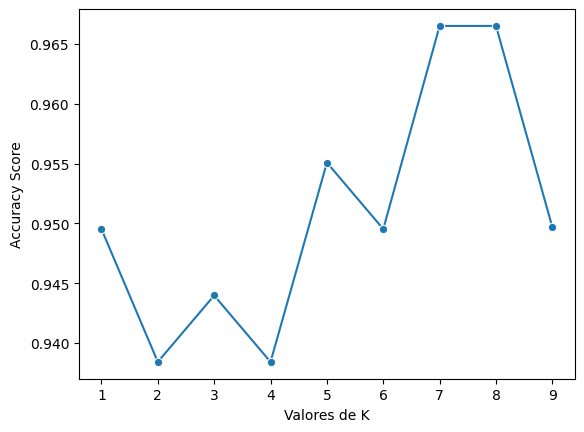

In [0]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("Valores de K")
plt.ylabel("Accuracy Score")

In [0]:
names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "Naive Bayes"
]

classifiers = [
    LogisticRegression(C=1.0, solver='lbfgs', multi_class='ovr'),
    KNeighborsClassifier(n_neighbors=7), #basado en el estudio anterio
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5), 
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=3
    ),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianNB(),
]

In [0]:
def create_dict_row(row, cm):
    dict_row = {
        "Modelo": row[0], 
        "Test Size": row[1], 
        "Accuracy Train": row[2], 
        "Accuracy Test": row[3], 
        "Precision Test": row[4], 
        "Recall Test": row[5], 
        "confusion_matrix": cm
    }
    return dict_row

In [0]:
def create_pretty_table():
    x = PrettyTable()
    x.field_names =  ["Modelo", "Test Size", "Accuracy Train", "Accuracy Test", "Precision Test", "Recall Test"]
    #x.field_names.append( ["confusion_matrix", "Prediction 1", "Prediction 2"] )
    x.align["Modelo"] = "l"
    x.align["Test Size"] = "r"
    x.align["Accuracy Train"] = "r"
    x.align["Accuracy Test"] = "r"
    x.align["Precision Test"] = "r"
    x.align["Recall Test"] = "r"
    #x.align["confusion_matrix"] = "c"
    #x.align["Prediction 1"] = "r"
    #x.align["Prediction 2"] = "r"    
    return x

In [0]:
data_model_train = []
#crear arreglo para validar con diferentes tamanos del train y test
test_sizes = [0.10, 0.15, 0.20, 0.25, 0.30]
for test_size in test_sizes:
    print(100*"=")
    print(f"Test Size: {test_size}")
    print(100*"=")
    #obtener los datos y no dejar los mismos
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size)

    x = create_pretty_table()
    # iterar sobre  classifiers
    for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        
        y_pred = clf.predict(X_test)
        accuracy_pred = accuracy_score(y_test, y_pred)
        precision_pred = precision_score(y_test, y_pred, average="macro")
        recall_pred = recall_score(y_test, y_pred, average="macro")
        cm=confusion_matrix(y_test,y_pred)

        #print(80*"-")
        #print(name)
        #print("Accuracy:", score)
        #print("confusion_matrix")
        #print(cm)
        #report = classification_report(y_test,y_pred)
        #print(report)
        #y_predict1 = np.array([[13.72,1.43,2.5,16.7,108,3.4,3.67,0.19,2.04,6.8,0.89,2.87,1285]])
        #prediction1 = clf.predict(y_predict1)
        #print("Prediction 1:", prediction1)
        #y_predict2 = np.array([[12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520]])
        #prediction2 = clf.predict(y_predict2)
        #print("Prediction 2:", prediction2)
        #print(80*"-")

        new_row = [name, test_size, round(score, 6), round(accuracy_pred, 6), round(precision_pred, 6), round(recall_pred, 6) ]
        x.add_row(new_row)
        data_model_train.append( create_dict_row(new_row, cm) )

    print(x)
print(100*"=")
df_model_train = pd.DataFrame(data_model_train)

Test Size: 0.1
+---------------------+-----------+----------------+---------------+----------------+-------------+
| Modelo              | Test Size | Accuracy Train | Accuracy Test | Precision Test | Recall Test |
+---------------------+-----------+----------------+---------------+----------------+-------------+
| Logistic Regression |       0.1 |            1.0 |           1.0 |            1.0 |         1.0 |
| Nearest Neighbors   |       0.1 |            1.0 |           1.0 |            1.0 |         1.0 |
| Linear SVM          |       0.1 |            1.0 |           1.0 |            1.0 |         1.0 |
| RBF SVM             |       0.1 |       0.555556 |      0.555556 |       0.185185 |    0.333333 |
| Gaussian Process    |       0.1 |            1.0 |           1.0 |            1.0 |         1.0 |
| Decision Tree       |       0.1 |       0.888889 |      0.888889 |       0.944444 |    0.833333 |
| Random Forest       |       0.1 |            1.0 |           1.0 |            1.0 |

In [0]:
pd.set_option('display.max_rows', None)
df_model_train

,Modelo,Test Size,Accuracy Train,Accuracy Test,Precision Test,Recall Test,confusion_matrix
0,Logistic Regression,0.10,1.000000,1.000000,1.000000,1.000000,"[[6, 0, 0], [0, 6, 0], [0, 0, 6]]"
1,Nearest Neighbors,0.10,1.000000,1.000000,1.000000,1.000000,"[[6, 0, 0], [0, 6, 0], [0, 0, 6]]"
2,Linear SVM,0.10,1.000000,1.000000,1.000000,1.000000,"[[6, 0, 0], [0, 6, 0], [0, 0, 6]]"
3,RBF SVM,0.10,0.333333,0.333333,0.111111,0.333333,"[[0, 6, 0], [0, 6, 0], [0, 6, 0]]"
4,Gaussian Process,0.10,1.000000,1.000000,1.000000,1.000000,"[[6, 0, 0], [0, 6, 0], [0, 0, 6]]"
5,Decision Tree,0.10,0.833333,0.833333,0.888889,0.833333,"[[5, 1, 0], [0, 6, 0], [0, 2, 4]]"
6,Random Forest,0.10,1.000000,1.000000,1.000000,1.000000,"[[6, 0, 0], [0, 6, 0], [0, 0, 6]]"
7,Neural Net,0.10,1.000000,1.000000,1.000000,1.000000,"[[6, 0, 0], [0, 6, 0], [0, 0, 6]]"
8,Naive Bayes,0.10,0.944444,0.944444,0.952381,0.944444,"[[5, 1, 0], [0, 6, 0], [0, 0, 6]]"
9,Logistic Regression,0.15,0.962963,0.962963,0.966667,0.962963,"[[9, 0, 0], [1, 8, 0], [0, 0, 9]]"


[Text(0.5, 0.9166666666666666, 'X[12] <= 760.0\ngini = 0.657\nsamples = 141\nvalue = [50, 55, 36]'),
 Text(0.25, 0.75, 'X[9] <= 4.85\ngini = 0.492\nsamples = 85\nvalue = [2, 52, 31]'),
 Text(0.125, 0.5833333333333334, 'X[6] <= 0.545\ngini = 0.196\nsamples = 56\nvalue = [2, 50, 4]'),
 Text(0.0625, 0.4166666666666667, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.1875, 0.4166666666666667, 'X[11] <= 1.48\ngini = 0.108\nsamples = 53\nvalue = [2, 50, 1]'),
 Text(0.125, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.25, 0.25, 'X[2] <= 2.825\ngini = 0.074\nsamples = 52\nvalue = [2, 50, 0]'),
 Text(0.1875, 0.08333333333333333, 'gini = 0.038\nsamples = 51\nvalue = [1, 50, 0]'),
 Text(0.3125, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.375, 0.5833333333333334, 'X[6] <= 2.375\ngini = 0.128\nsamples = 29\nvalue = [0, 2, 27]'),
 Text(0.3125, 0.4166666666666667, 'gini = 0.0\nsamples = 27\nvalue = [0, 0, 27]'),
 Text(0.4375, 0.4166666666666667, '

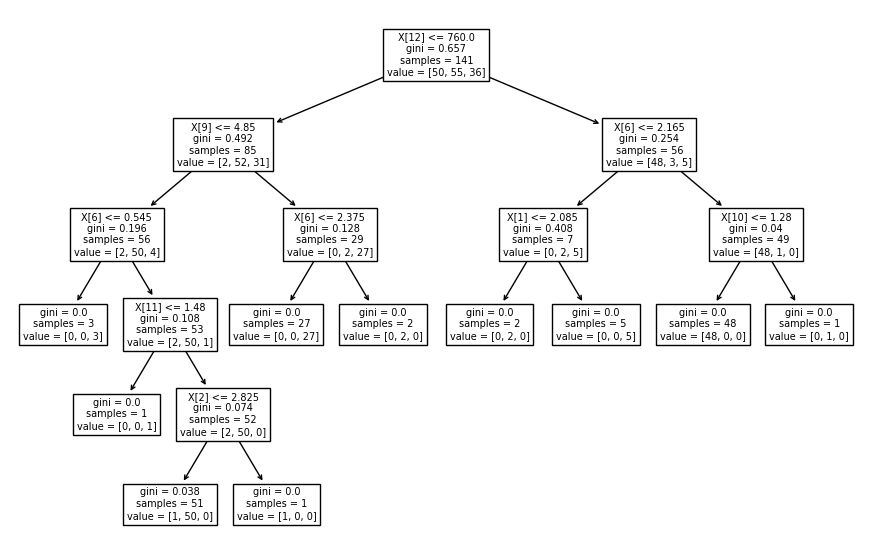

In [0]:

from sklearn import tree
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
plt.figure(figsize=(11,7))
tree.plot_tree(clf)